# Amazon Top 50 Bestselling Books - EDA & Hypothesis Test

<div style="display:fill; padding:10px 15px;
           border-radius:5px;
           background-color:#EBEBD8;
           letter-spacing:0.5px"><span style="font-size:20px; color:#960; font-weight:bold">1. Importing Datasets</span></div>

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import fuzzywuzzy
from fuzzywuzzy import process
import collections
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.figure_factory as ff

from scipy.stats import shapiro
from scipy.stats import mannwhitneyu

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
# Reading data
df = pd.read_csv('../input/amazon-top-50-bestselling-books-2009-2019/bestsellers with categories.csv') # Loading data
df.head() # Displaying the first 5 lines of the dataset

,Name,Author,User Rating,Reviews,Price,Year,Genre
0,10-Day Green Smoothie Cleanse,JJ Smith,4.7,17350,8,2016,Non Fiction
1,11/22/63: A Novel,Stephen King,4.6,2052,22,2011,Fiction
2,12 Rules for Life: An Antidote to Chaos,Jordan B. Peterson,4.7,18979,15,2018,Non Fiction
3,1984 (Signet Classics),George Orwell,4.7,21424,6,2017,Fiction
4,"5,000 Awesome Facts (About Everything!) (Natio...",National Geographic Kids,4.8,7665,12,2019,Non Fiction


<div style="display:fill; padding:10px 15px;
           border-radius:5px;
           background-color:#EBEBD8;
           letter-spacing:0.5px"><span style="font-size:20px; color:#960; font-weight:bold">2. Data Description</span></div>

In [3]:
# Let's look at the dimension of the data
print(f'Data contain {df.shape[0]} records and {df.shape[1]} columns.')

Data contain 550 records and 7 columns.


In [4]:
# Get concise summary of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550 entries, 0 to 549
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         550 non-null    object 
 1   Author       550 non-null    object 
 2   User Rating  550 non-null    float64
 3   Reviews      550 non-null    int64  
 4   Price        550 non-null    int64  
 5   Year         550 non-null    int64  
 6   Genre        550 non-null    object 
dtypes: float64(1), int64(3), object(3)
memory usage: 30.2+ KB


In [5]:
# Data type of each columns
print(df.dtypes)

Name            object
Author          object
User Rating    float64
Reviews          int64
Price            int64
Year             int64
Genre           object
dtype: object


<div style="display:fill; padding:10px 15px;
           border-radius:5px;
           background-color:#EBEBD8;
           letter-spacing:0.5px"><span style="font-size:20px; color:#960; font-weight:bold">3. Data Wrangling</span></div>

In [6]:
# Check missing values
df.isnull().sum()

Name           0
Author         0
User Rating    0
Reviews        0
Price          0
Year           0
Genre          0
dtype: int64

> <span style="font-size:16px;">The data has no missing values, so no further transformations are required.</span>

In [7]:
# Check duplicate values
df.duplicated().sum()

0

> <span style="font-size:16px;">The data has no duplicate values, so no further transformations are required.</span>

In [8]:
# Forming categorical columns
cat_col = list(df.select_dtypes(exclude=('int', 'float')).columns)
print(f'Categorical columns : {", ".join(cat_col)}.')

Categorical columns : Name, Author, Genre.


In [9]:
# Check for spelling errors in entire dataset
for col in cat_col:
    print(f'Actual {col}: "{len(set(df[col]))}" - After Spell Check {col}: "{len(set(df[col].str.title().str.strip()))}"')

Actual Name: "351" - After Spell Check Name: "350"
Actual Author: "248" - After Spell Check Author: "248"
Actual Genre: "2" - After Spell Check Genre: "2"


In [10]:
# Correct the errors
df.Name = df.Name.str.title().str.strip()

In [11]:
# Check if the changes have passed
for col in cat_col:
    print(f'Actual {col}: "{len(set(df[col]))}" - After Spell Check {col}: "{len(set(df[col].str.title().str.strip()))}"')

Actual Name: "350" - After Spell Check Name: "350"
Actual Author: "248" - After Spell Check Author: "248"
Actual Genre: "2" - After Spell Check Genre: "2"


<span style="font-size:16px;">Let's check if there are the same author names but with different spellings.</span>

In [12]:
# Check for spelling errors in Author column
authors = df.Author.sort_values().unique()
authors

array(['Abraham Verghese', 'Adam Gasiewski', 'Adam Mansbach', 'Adir Levy',
       'Admiral William H. McRaven', 'Adult Coloring Book Designs',
       'Alan Moore', 'Alex Michaelides', 'Alice Schertle', 'Allie Brosh',
       'American Psychiatric Association',
       'American Psychological Association', 'Amor Towles', 'Amy Ramos',
       'Amy Shields', 'Andy Weir', 'Angie Grace', 'Angie Thomas',
       'Ann Voskamp', 'Ann Whitford Paul', 'Anthony Bourdain',
       'Anthony Doerr', 'Atul Gawande', 'Audrey Niffenegger',
       'B. J. Novak', 'Bessel van der Kolk M.D.', 'Bill Martin Jr.',
       "Bill O'Reilly", 'Bill Simmons', 'Blue Star Coloring',
       'Bob Woodward', 'Brandon Stanton', 'Brené Brown',
       'Brian Kilmeade', 'Bruce Springsteen', 'Carol S. Dweck',
       'Celeste Ng', 'Charlaine Harris', 'Charles Duhigg',
       'Charles Krauthammer', 'Cheryl Strayed', 'Chip Gaines',
       'Chip Heath', 'Chris Cleave', 'Chris Kyle', 'Chrissy Teigen',
       'Christina Baker Kline', 

> <span style="font-size:16px;">Observe that names with initial have a tendency to be in different varaiations.
> George R. R. Martin and J. K. Rowling fall into this category.</span>

In [13]:
# Let's build a list of the most similar spellings for the first Author with this error
matches_author_name = fuzzywuzzy.process.extract('George R.R. Martin', authors, limit=4, scorer=fuzzywuzzy.fuzz.token_sort_ratio)
matches_author_name

[('George R. R. Martin', 100),
 ('George R.R. Martin', 100),
 ('George Orwell', 53),
 ('Bill Martin Jr.', 52)]

In [14]:
# Let's build a list of the most similar spellings for the second Author with this error
matches_author_name = fuzzywuzzy.process.extract('J. K. Rowling', authors, limit=4, scorer=fuzzywuzzy.fuzz.token_sort_ratio)
matches_author_name

[('J. K. Rowling', 100),
 ('J.K. Rowling', 100),
 ('Mark Owen', 50),
 ('Mark Twain', 48)]

In [15]:
# Replace the names of the Authors with the correct ones
df = df.replace('George R. R. Martin', 'George R.R. Martin')
df = df.replace('J. K. Rowling', 'J.K. Rowling')

In [16]:
# Check if the changes have passed
for col in cat_col:
    print(f'Before {col}: {len(set(df[col]))} After {col}: {len(set(df[col].str.title().str.strip()))}')

Before Name: 350 After Name: 350
Before Author: 246 After Author: 246
Before Genre: 2 After Genre: 2


In [17]:
# Check the column Genre
genre = df.Genre.unique()
genre

array(['Non Fiction', 'Fiction'], dtype=object)

> <span style="font-size:16px;">Everything is fine with genres.</span>

In [18]:
# Check the column Year
years = list(df.Year.unique())
sorted(years)

[2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]

> <span style="font-size:16px;">Everything is fine with years.</span>

<div style="display:fill; padding:10px 15px;
           border-radius:5px;
           background-color:#EBEBD8;
           letter-spacing:0.5px"><span style="font-size:20px; color:#960; font-weight:bold">4. Exploratory Data Analysis (EDA)</span></div>

<span style="padding-left:17px; font-size:18px; color:#339; font-weight:bold">4.1. Genre Distribution</span>

Non Fiction    310
Fiction        240
Name: Genre, dtype: int64

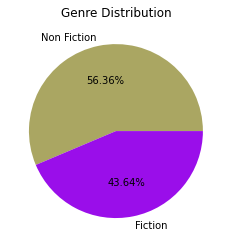

In [19]:
# Genre distribution
colors = ['#aaa662','#9a0eea']
plt.pie(df['Genre'].value_counts(), autopct = '%1.2f%%', labels = df['Genre'].value_counts().index, colors=colors)
plt.title('Genre Distribution');
df['Genre'].value_counts()

<span style="font-size:16px; font-weight:bold">✔️ INSIGHT:</span>
<span style="font-size:16px;">By analyzing the genre distribution, Non-fiction is more likely to become a bestseller. Later we will find out how users relate to these genres.</span>

<span style="padding-left:17px; font-size:18px; color:#339; font-weight:bold">4.2. Trends & Outliers</span>

<span style="font-size:16px;">Let's look at the measures of the central trend that characterize the distribution of numerical values in the data. We render a box-plot for each numeric variable.</span>

In [20]:
# Display summary statistical
df.describe()

,User Rating,Reviews,Price,Year
count,550.000000,550.000000,550.000000,550.000000
mean,4.618364,11953.281818,13.100000,2014.000000
std,0.226980,11731.132017,10.842262,3.165156
min,3.300000,37.000000,0.000000,2009.000000
25%,4.500000,4058.000000,7.000000,2011.000000
50%,4.700000,8580.000000,11.000000,2014.000000
75%,4.800000,17253.250000,16.000000,2017.000000
max,4.900000,87841.000000,105.000000,2019.000000


<span style="padding-left:20px; font-size:18px; color:#339; font-weight:bold">4.2.1 User Rating Trends & Outliers</span>

In [21]:
# Let's set the visualization parameters
user_rating_bp = make_subplots(rows=1, cols=1, specs=[[{'type': 'xy'}]])

# Setting Box parameters
user_rating_bp.add_trace(go.Box(x=df['User Rating'], 
                       name='User Rating'))

# Setting the parameters of the Box when displaying
user_rating_bp.update_traces(marker_color='#aaa662')

# Setting the parameters of the Box when displaying
user_rating_bp.update_layout(title='User Rating Trends & Outliers',showlegend=False, 
                    template='simple_white', 
                    font=dict(family='Arial', 
                              size=12, 
                              color='black'))

# Displaying the Box
user_rating_bp.show()

<span style="padding-left:20px; font-size:18px; color:#339; font-weight:bold">4.2.2 Reviews Trends & Outliers</span>

In [22]:
# Let's set the visualization parameters
review_bp = make_subplots(rows=1, cols=1, specs=[[{'type': 'xy'}]])

# Setting Box parameters
review_bp.add_trace(go.Box(x=df['Reviews'], 
                       name='Reviews'))

# Setting the parameters of the Box when displaying
review_bp.update_traces(marker_color='#aaa662')

# Setting the parameters of the Box when displaying
review_bp.update_layout(title='Reviews Trends & Outliers', showlegend=False, 
                    template='simple_white', 
                    font=dict(family='Arial', 
                              size=12, 
                              color='black'))

# Displaying the Box
review_bp.show()

<span style="padding-left:20px; font-size:18px; color:#339; font-weight:bold">4.2.3 Price Trends & Outliers</span>

In [23]:
# Let's set the visualization parameters
price_bp = make_subplots(rows=1, cols=1, specs=[[{'type': 'xy'}]])

# Setting Box parameters
price_bp.add_trace(go.Box(x=df['Price'], 
                       name='Price'))

# Setting the parameters of the Box when displaying
price_bp.update_traces(marker_color='#aaa662')

# Setting the parameters of the Box when displaying
price_bp.update_layout(title='Price Trends & Outliers', showlegend=False, 
                    template='simple_white', 
                    font=dict(family='Arial', 
                              size=12, 
                              color='black'))

# Displaying the Box
price_bp.show()

<span style="font-size:16px; font-weight:bold">✔️ INSIGHT: <br/></span>
<span style="font-size:16px;">By analyzing the numeric data, it is established:</span>

<span style="font-size:16px;"><p style="font-weight:bold">User Rating:<br/></p></span>

<span style="font-size:16px;">1. Data is not distributed normally. Asymmetry is observed.<br/></span>
<span style="font-size:16px;">2. Average and median book ratings are 4.7.<br/></span>
<span style="font-size:16px;">3. There are outliers in the data. There are a small number of books in the data below the 4.1 rating.<br/></span>

<span style="font-size:16px;"><p style="font-weight:bold">Reviews:<br/></p></span>

<span style="font-size:16px;">1. Data is not distributed normally. Asymmetry is observed.<br/></span>
<span style="font-size:16px;">2. The data has a wide range.<br/></span>
<span style="font-size:16px;">3. There are outliers in the data. There are a small number of books receiving reviews well above the 75 percentile.<br/></span>

<span style="font-size:16px;"><p style="font-weight:bold">Price:<br/></p></span>

<span style="font-size:16px;">1. Data is not distributed normally. Asymmetry is observed.<br/></span>
<span style="font-size:16px;">2. There are books that cost much higher than the average, as well as books with a cost of 0, which is strange.There are books that cost much higher than the average, as well as books with a cost of 0, which is strange. Either the book is given for free or this error.<br/></span>

<span style="padding-left:17px; font-size:18px; color:#339; font-weight:bold">4.3. Correlation In The Data</span>

<span style="font-size:16px;">Let's look at the correlation in the data.</span>

Pairwise correlation of all columns in the dataframe




<AxesSubplot:>

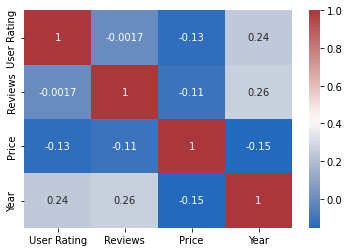

In [24]:
# Correlation in the data
print('\033[1m'+"Pairwise correlation of all columns in the dataframe")
print()
df.corr()
print()
sns.heatmap(df.corr(),annot=True,cmap="vlag")

<span style="font-size:18px; color:#339;">

<span style="padding-left:20px; font-size:18px; color:#339; font-weight:bold">4.3.1 Reviews vs. User Rating</span>

<AxesSubplot:xlabel='User Rating', ylabel='Reviews'>

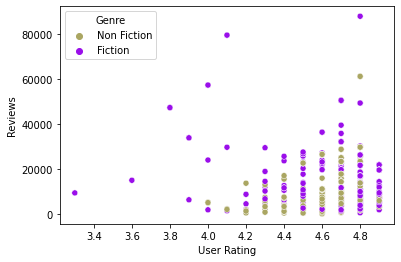

In [25]:
# Correlation between reviews and user rating
color_dict = dict({'Non Fiction':'#aaa662', 'Fiction':'#9a0eea'})
sns.scatterplot(data=df, x="User Rating", y="Reviews", hue="Genre", palette=color_dict)

<span style="padding-left:20px; font-size:18px; color:#339; font-weight:bold">4.3.2 Price vs. User Rating</span>

<AxesSubplot:xlabel='User Rating', ylabel='Price'>

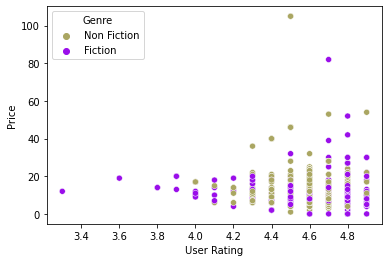

In [26]:
# Correlation between price and user rating
color_dict = dict({'Non Fiction':'#aaa662', 'Fiction':'#9a0eea'})
sns.scatterplot(data=df, x="User Rating", y="Price", hue="Genre", palette=color_dict)

<span style="padding-left:20px; font-size:18px; color:#339; font-weight:bold">4.3.3 Reviews vs. Price</span>

<AxesSubplot:xlabel='Price', ylabel='Reviews'>

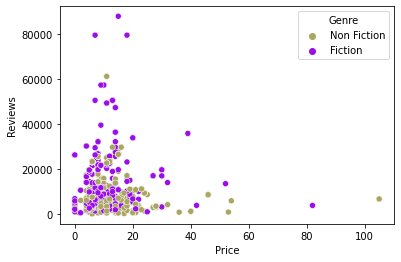

In [27]:
# Correlation between reviews and price
color_dict = dict({'Non Fiction':'#aaa662', 'Fiction':'#9a0eea'})
sns.scatterplot(data=df, x="Price", y="Reviews", hue="Genre", palette=color_dict)

<span style="font-size:16px; font-weight:bold">✔️ INSIGHT:</span>
<span style="font-size:16px;">Based on the constructed correlation matrix as well as the constructed visualizations, it can be seen that the data does not contain any positive or negative linear relationship between the rating, reviews and the price of books.</span>

<span style="padding-left:17px; font-size:18px; color:#339; font-weight:bold">4.4. The Most Popular Authors & The Most Popular Books</span>

<span style="padding-left:20px; font-size:18px; color:#339; font-weight:bold">4.4.1 The Most Popular Author</span>

In [28]:
# The most popular authors
authors = df.groupby('Author').agg({'User Rating':'mean', 'Reviews':'sum', 'Name': 'count'}).rename({'Name': 'Total Books'}, axis = 1)
authors.sort_values(['User Rating', 'Reviews'], ascending = (False, False)).head(10)

,User Rating,Reviews,Total Books
Author,,,
Eric Carle,4.9,136822,7
Sarah Young,4.9,117456,6
Dav Pilkey,4.9,51496,7
Emily Winfield Martin,4.9,35368,4
Bill Martin Jr.,4.9,28688,2
Sherri Duskey Rinker,4.9,14076,2
Jill Twiss,4.9,11881,1
Rush Limbaugh,4.9,10986,2
Nathan W. Pyle,4.9,9382,1


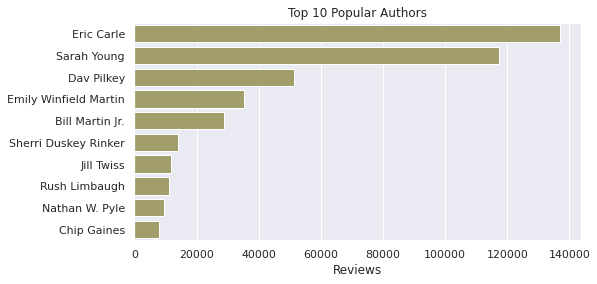

In [29]:
# Visualize most popular authors
authors = df.groupby('Author').agg({'User Rating':'mean', 'Reviews':'sum', 'Name': 'count'}).rename({'Name': 'Total Books'}, axis = 1)
authors = authors.sort_values(['User Rating', 'Reviews'], ascending = (False, False)).head(10).reset_index()

sns.set(rc = {'figure.figsize': (8, 4)})
ax = sns.barplot(x="Reviews", y="Author", data=authors, color="#aaa662").set(title="Top 10 Popular Authors", ylabel=None)

<span style="padding-left:20px; font-size:18px; color:#339; font-weight:bold">4.4.2 The Most Popular Books</span>

In [30]:
# The moost popular books
books = df.groupby('Name').agg({'User Rating':'mean', 'Reviews':'sum', 'Name': 'count'}).rename({'Name': 'Total Books'}, axis = 1)
books.sort_values(['User Rating', 'Reviews'], ascending = (False, False)).head(10)

,User Rating,Reviews,Total Books
Name,,,
"Oh, The Places You'Ll Go!",4.9,174672,8
The Very Hungry Caterpillar,4.9,136822,7
Jesus Calling: Enjoying Peace In His Presence (With Scripture References),4.9,117456,6
The Wonderful Things You Will Be,4.9,35368,4
"Brown Bear, Brown Bear, What Do You See?",4.9,28688,2
"Harry Potter And The Chamber Of Secrets: The Illustrated Edition (Harry Potter, Book 2)",4.9,19622,1
Dog Man: Brawl Of The Wild: From The Creator Of Captain Underpants (Dog Man #6),4.9,14470,2
"Goodnight, Goodnight Construction Site (Hardcover Books For Toddlers, Preschool Books For Kids)",4.9,14076,2
Dog Man: Fetch-22: From The Creator Of Captain Underpants (Dog Man #8),4.9,12619,1


/opt/conda/lib/python3.7/site-packages/IPython/core/events.py:89: UserWarning:

Glyph 146 (\x92) missing from current font.

/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 146 (\x92) missing from current font.



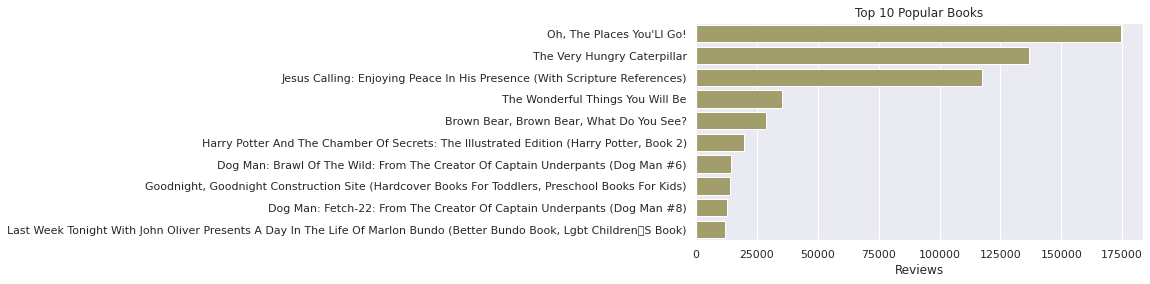

In [31]:
# Visualize most popular books
books = df.groupby('Name').agg({'User Rating':'mean', 'Reviews':'sum', 'Name': 'count'}).rename({'Name': 'Total Books'}, axis = 1)
books = books.sort_values(['User Rating', 'Reviews'], ascending = (False, False)).head(10).reset_index()

sns.set(rc = {'figure.figsize': (8, 4)})
ax = sns.barplot(x="Reviews", y="Name", data=books, color="#aaa662").set(title="Top 10 Popular Books", ylabel=None)

<span style="padding-left:17px; font-size:18px; color:#339; font-weight:bold">4.5. Distribution of Data</span>

<span style="padding-left:20px; font-size:18px; color:#339; font-weight:bold">4.5.1 Distribution of User Rating</span>

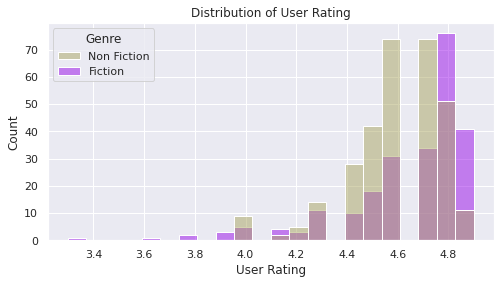

In [32]:
# Rating distribution
plt.title('Distribution of User Rating')
color_dict = dict({'Non Fiction':'#aaa662', 'Fiction':'#9a0eea'})
sns.histplot(x = 'User Rating', hue = 'Genre', data = df, palette = color_dict);

<span style="font-size:16px; font-weight:bold">✔️ INSIGHT:</span>
<span style="font-size:16px;">Users give the most ratings on the numbers 4.6, 4.7, and 4.8 and the maximum rating is at 4.8.</span>

<span style="padding-left:20px; font-size:18px; color:#339; font-weight:bold">4.5.2 Distribution of Review</span>

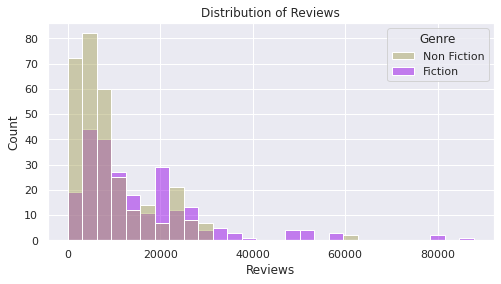

In [33]:
# Reviews distribution
plt.title('Distribution of Reviews')
color_dict = dict({'Non Fiction':'#aaa662', 'Fiction':'#9a0eea'})
sns.histplot(x = 'Reviews', hue = 'Genre', data = df, palette = color_dict);

<span style="font-size:16px; font-weight:bold">✔️ INSIGHT:</span>
<span style="font-size:16px;">The average number of reviews is under 20,000 for both genres.
There are several reviews with a total of over 40,000 for the Fiction genre.</span>

<span style="padding-left:20px; font-size:18px; color:#339; font-weight:bold">4.5.3 Distribution of Price</span>

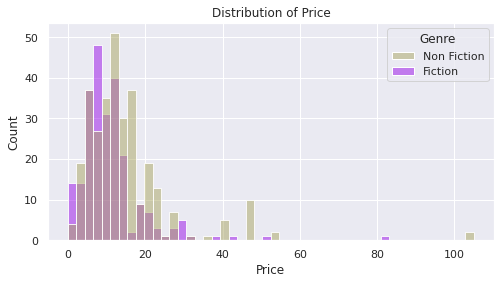

In [34]:
# Price distribution
plt.title('Distribution of Price')
color_dict = dict({'Non Fiction':'#aaa662', 'Fiction':'#9a0eea'})
sns.histplot(x = 'Price', hue = 'Genre', data = df, palette = color_dict);

<span style="font-size:16px; font-weight:bold">✔️ INSIGHT:</span>
<span style="font-size:16px;">The price range is mostly under 20.
There are only a few that are in the range above 20 and above 40.</span>

<span style="padding-left:17px; font-size:18px; color:#339; font-weight:bold">4.6. Yearly Trends</span>

<span style="padding-left:20px; font-size:18px; color:#339; font-weight:bold">4.6.1 Average Ratings by Year</span>

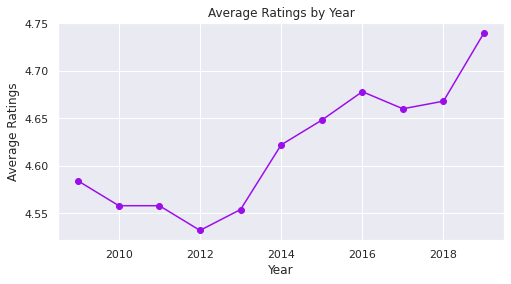

In [35]:
# Average ratings by year
df.groupby('Year')['User Rating'].mean().plot(marker = 'o', c = '#9a0eea')
plt.title('Average Ratings by Year')
plt.xlabel('Year')
plt.ylabel('Average Ratings');

<span style="padding-left:20px; font-size:18px; color:#339; font-weight:bold">4.6.2 Total Reviews by Year</span>

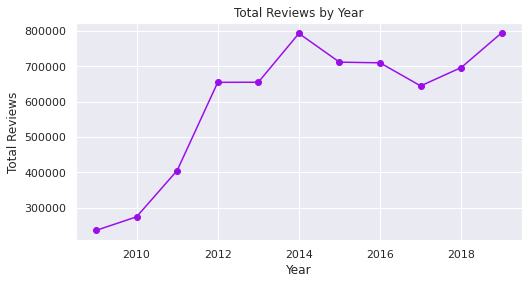

In [36]:
# Total reviews by year
df.groupby('Year')['Reviews'].sum().plot(marker = 'o', c = '#9a0eea')
plt.title('Total Reviews by Year')
plt.xlabel('Year')
plt.ylabel('Total Reviews');

<div style="display:fill; padding:10px 15px;
           border-radius:5px;
           background-color:#EBEBD8;
           letter-spacing:0.5px"><span style="font-size:20px; color:#960; font-weight:bold">5. Hypothesis Testing</span></div>

<span style="font-size:16px;">In this article, let us test the following hypothesis: "Do genres differ in terms of rating?"</span>

<span style="font-size:16px;">We will test the hypothesis according to the following algorithm:</span>

<span style="font-size:16px;">Null and alternative hypotheses are formulated.</span>
<span style="font-size:16px;">The distribution was checked for normality using "Shapiro Wilk test of normality".</span>
<span style="font-size:16px;">Two samples were formed. Books related to the Non Fiction genre and books related to the Fiction genre.</span>
<span style="font-size:16px;">Testing was carried out in order to identify statistical differences between the study groups.</span>

<span style="font-size:16px;">1. Let us formulate the null and alternative hypotheses.</span>

<span style="font-size:16px;">H0 - There are no differences between genre racketeering</span>

<span style="font-size:16px;">H1 - There are differences between genre racketeering</span>

<span style="font-size:16px;">2. Checking the distribution for normality. Using "Shapiro Wilk test of normality".</span>

In [37]:
# Set the alpha level
alpha=0.05

# We pass groups to the criterion for testing
stat, pval = shapiro(df['User Rating'])

print('Statistic:', f'{stat:.3f}')
print('P-Value:', f'{pval:.20f}')
    
# Checking the condition for accepting or rejecting H0
if pval > alpha:
    print('Accept H0 - Data is distributed normally.')
if pval < alpha:
    print('Reject H0 - Data is not distributed normally.')

Statistic: 0.872
P-Value: 0.00000000000000000001
Reject H0 - Data is not distributed normally.


<span style="font-size:16px;">3. Let's form two samples for testing.</span>

In [38]:
# Create group
non_fiction = df[df['Genre'] == 'Non Fiction']['User Rating']
fiction = df[df['Genre'] == 'Fiction']['User Rating']

<span style="font-size:16px;">4. Let's carry out testing. Since the nadi data in the samples are not normally distributed, we will use the nonparametric Mann-Whitney test.</span>

In [39]:
# Set the alpha level
alpha=0.05

# We pass groups to the criterion for testing
stat, pval = mannwhitneyu(non_fiction, fiction)

print('Statistic:', f'{stat:.3f}')
print('P-Value:', f'{pval:.20f}')
 
# Checking the condition for accepting or rejecting H0
if pval > alpha:
    print('Accept H0 - There is no significant difference between the groups.')
if pval < alpha:
    print('Reject H0 - There are significant differences between the groups.')

Statistic: 27490.500
P-Value: 0.00000009714708137283
Reject H0 - There are significant differences between the groups.


<span style="font-size:16px;">Let's compare the median values in the groups.</span>

In [40]:
print(f'Non_fiction median: {non_fiction.median()}, Fiction median: {fiction.median()}')

Non_fiction median: 4.6, Fiction median: 4.7


<span style="font-size:16px;">Visualizing the density of distribution in samples.</span>

In [41]:
# Create distplot with curve_type set to 'normal'
den_dist = ff.create_distplot([non_fiction, fiction], 
                         ['Non Fiction', 'Fiction'], 
                         colors=['#aaa662', '#9a0eea',],
                         bin_size=.1, 
                         show_rug=False)

# Add title
den_dist.update_layout(title_text='Сomparison of the distribution density in Non Fiction and Fiction group', 
                     template='simple_white',
                     font=dict(family='Arial', size=12, color='black'))
den_dist.show()

<span style="font-size:16px; font-weight:bold">✔️ INSIGHT:</span>
<span style="font-size:16px;">As a result of the testing, statistically significant differences were obtained between the compared groups. Based on the results obtained, it can be argued that users evaluate books differently depending on the genre, and based on the median values, readers give preference to works of fiction.</span>